# LeNet-5 in TF

#### Dependencies

In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from matplotlib import pyplot as plt

#### Load Data

In [2]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    return plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
print(mnist.test.images.shape)
print(mnist.test.labels.shape)


(10000, 784)
(10000, 10)


(55000, 10)
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


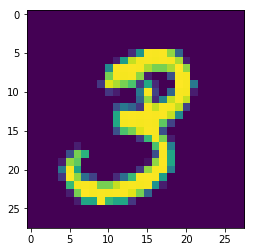

In [5]:
index = 1
print(mnist.train.labels.shape)
print(mnist.train.labels[index])
gen_image(mnist.train.images[index]).show()

#### Set hyperparameters

In [6]:
epochs = 10
batch_size = 128
weight_initializer = tf.contrib.layers.xavier_initializer()
display_progress = 40

#### Set parameters for each layer

In [7]:
# input layer
n_input = 784

# first convolutional layer
n_conv_1 =32
k_conv_1 = 3

# second convolutional layer
n_conv_2 = 64
k_conv_2 = 3

# max pooling layer
pool_size = 2
mp_layer_dropout = 0.25

# dense layer
n_dense = 128
dense_layer_dropout = 0.5

#output layer
n_classes = 10

#### Define placeholder Tensors

In [8]:
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

#### Define layers

In [9]:
#dense layer with ReLU
def dense(x, W, b):
    z = tf.add(tf.matmul(x,W),b)
    a = tf.nn.relu(z)
    return a

#conv layer with ReL:
def conv2d(x,W,b,stride_length=1):
    xW = tf.nn.conv2d(x,W, strides=[1, stride_length,stride_length,1], padding='SAME')
    z = tf.nn.bias_add(xW,b)
    a = tf.nn.relu(z)
    return a

#max pooling layer:
def maxpooling2d(x,p_size):
    return tf.nn.max_pool(x, ksize=(1,p_size,p_size,1),
                         strides=[1,p_size,p_size,1],
                         padding='SAME')

#### Design neural network architecture 

In [10]:
def network(x, weights, biases, n_in, mp_psize, mp_dropout, dense_dropout):
    
    # reshape input data
    square_dimensions = int(np.sqrt(n_in))
    square_x = tf.reshape(x, shape=[-1, square_dimensions, square_dimensions, 1])

    #convolutional layers
    conv_1 = conv2d(square_x, weights['W_c1'],biases['b_c1'])
    conv_2 = conv2d(conv_1, weights['W_c2'],biases['b_c2'])
    pool_1 = maxpooling2d(conv_2, mp_psize)
    pool_1 = tf.nn.dropout(pool_1, 1-mp_dropout)
    
    #dense layer
    flat = tf.reshape(pool_1, [-1, weights['W_d1'].get_shape().as_list()[0]])
    print(weights['W_d1'].get_shape())
    print(flat.get_shape())
    dense_1 = dense(flat, weights['W_d1'],biases['b_d1'])
    dense_1 = tf.nn.dropout(dense_1, 1-dense_dropout)
    
    
    # linear output layer
    out_layer_z = tf.add(tf.matmul(dense_1, weights['W_out']),biases['b_out'])
    return out_layer_z 
    

#### Define variable dictionaries

In [11]:
bias_dict = {
    'b_c1' : tf.Variable(tf.zeros([n_conv_1])),
    'b_c2' : tf.Variable(tf.zeros([n_conv_2])),
    'b_d1' : tf.Variable(tf.zeros([n_dense])),
    'b_out' : tf.Variable(tf.zeros([n_classes]))
    
}


full_square_length = np.sqrt(n_input)
pooled_square_length = int(full_square_length/pool_size)
dense_inputs= pooled_square_length**2 * n_conv_2

weights_dict = {
    'W_c1' : tf.get_variable('W_c1', [k_conv_1,k_conv_1, 1, n_conv_1], initializer=weight_initializer),
    'W_c2' : tf.get_variable('W_c2', [k_conv_2,k_conv_2, n_conv_1, n_conv_2], initializer=weight_initializer),
    'W_d1' : tf.get_variable('W_d1', [dense_inputs,n_dense], initializer=weight_initializer),
    'W_out': tf.get_variable('W_out', [n_dense, n_classes], initializer=weight_initializer)
}

#### Build model

In [12]:
predictions = network(x, weights_dict, bias_dict, n_input, pool_size, mp_layer_dropout,
                     dense_layer_dropout)


(12544, 128)
(?, 12544)


In [13]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

#### Define evaluation metrics

In [14]:
correct_prediction = tf.equal(tf.argmax(predictions,1), tf.argmax(y,1))
accuracy_pct = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))*100

#### Initialization Op

In [15]:
initializer_op = tf.global_variables_initializer()

#### Train network in a session

In [16]:
with tf.Session() as session:
    session.run(initializer_op)
    print("Training for ", epochs, " epochs.")
    
    for epoch in range(epochs):
        
        avg_cost= 0.0
        avg_accuracy_pct=0.0
        
        n_batches = int(mnist.train.num_examples / batch_size)
        for i in range(n_batches):
            
            # reassurance 
            if i%display_progress == 0:
                print("Step ", i+1, " of ", n_batches, " in epoch ", epoch+1, ".", sep='')
                
            batch_x, batch_y =  mnist.train.next_batch(batch_size)
            _, batch_cost, batch_acc = session.run([optimizer, cost, accuracy_pct],
                feed_dict={x:batch_x,y: batch_y})
            avg_cost += batch_cost/n_batches
            avg_accuracy_pct += batch_acc/n_batches
        
        # output logs at end of each epoch of training:
        print("Epoch ", '%03d' % (epoch+1), 
              ": cost = ", '{:.3f}'.format(avg_cost), 
              ", accuracy = ", '{:.2f}'.format(avg_accuracy_pct), "%", 
              sep='')
    
    print("Training Complete. Testing Model.\n")
                    
    test_cost = cost.eval({x: mnist.test.images, y: mnist.test.labels})
    test_accuracy_pct = accuracy_pct.eval({x: mnist.test.images, y: mnist.test.labels})  
                    
    print("Test Cost:", '{:.3f}'.format(test_cost))
    print("Test Accuracy: ", '{:.2f}'.format(test_accuracy_pct), "%", sep='')

Training for  10  epochs.
Step 1 of 429 in epoch 1.
Step 41 of 429 in epoch 1.
Step 81 of 429 in epoch 1.
Step 121 of 429 in epoch 1.
Step 161 of 429 in epoch 1.
Step 201 of 429 in epoch 1.
Step 241 of 429 in epoch 1.
Step 281 of 429 in epoch 1.
Step 321 of 429 in epoch 1.
Step 361 of 429 in epoch 1.
Step 401 of 429 in epoch 1.
Epoch 001: cost = 0.266, accuracy = 91.86%
Step 1 of 429 in epoch 2.
Step 41 of 429 in epoch 2.
Step 81 of 429 in epoch 2.
Step 121 of 429 in epoch 2.
Step 161 of 429 in epoch 2.
Step 201 of 429 in epoch 2.
Step 241 of 429 in epoch 2.
Step 281 of 429 in epoch 2.
Step 321 of 429 in epoch 2.
Step 361 of 429 in epoch 2.
Step 401 of 429 in epoch 2.
Epoch 002: cost = 0.095, accuracy = 97.19%
Step 1 of 429 in epoch 3.
Step 41 of 429 in epoch 3.
Step 81 of 429 in epoch 3.
Step 121 of 429 in epoch 3.
Step 161 of 429 in epoch 3.
Step 201 of 429 in epoch 3.
Step 241 of 429 in epoch 3.
Step 281 of 429 in epoch 3.
Step 321 of 429 in epoch 3.
Step 361 of 429 in epoch 3.
Step